In [1]:
import seaborn as sns
import torch 
import torchvision
import torch.nn as nn
from lightning_gans.models.resnet import conv_downsample, conv_upsample
import pytorch_lightning as pl
from torchinfo import summary
import tqdm
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [8]:
class Autoencoder(pl.LightningModule):
    def __init__(self,latent_size):
        super().__init__()
        self.encoder =  torch.nn.Sequential(
            # Input = 3 x 28 x 28
            conv_downsample(ks=3,st=1,in_c=1,out_c=32),#norm=TR),
            # Input = 32 x 28 x 28
            conv_downsample(ks=3,st=2,in_c=32,out_c=64),#norm=False),
            # Input = 64 x 14 x 14
            conv_downsample(ks=3,st=2,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            conv_downsample(ks=3,st=1,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            nn.Flatten(),
            nn.Linear(in_features=64*7*7,out_features=latent_size),
            nn.Tanh()
        )
        self.decoder =  torch.nn.Sequential(
            # Input = 64 x 2 
            nn.Linear(in_features=latent_size,out_features=64*7*7),
            nn.LeakyReLU(inplace=True),
            nn.Unflatten(dim=1,unflattened_size=(64,7,7)),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=1,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 7 x 7
            conv_upsample(ks=3,st=2,in_c=64,out_c=64),#norm=False),
            # Input = 64 x 14 x 14
            conv_upsample(ks=3,st=2,in_c=64,out_c=32),#norm=False),
            # Input = 64 x 28 x 28
            conv_upsample(ks=3,st=1,in_c=32,out_c=1,norm=None,activation=None),
            nn.Sigmoid()
        )
        self.loss = nn.MSELoss()
        
    def configure_optimizers(self):
        self.opt = torch.optim.Adam(itertools.chain(self.encoder.parameters(),self.decoder.parameters()),lr=0.0005)
        return self.opt
    
    def training_step(self, train_batch, batch_idx):
        x,_ = train_batch
        x = self.encoder(x)
        x = self.decoder(x)
        return self.loss(train_batch[0],x)
        
    def forward(self,coords):
        return self.decoder(coords)

In [9]:
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
data = torchvision.datasets.MNIST('../data/raw/mnist/', train=True, download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=32,
                                          shuffle=True)
model = Autoencoder(latent_size=2)

In [10]:
trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=1,
    gpus=1,
    enable_progress_bar=True,
)
trainer.fit(model, train_dataloader=data_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 99.2 K
1 | decoder | Sequential | 102 K 
2 | loss    | MSELoss    | 0     
---------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)
/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a

Training: 0it [00:00, ?it/s]

/home/aahan/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Show embedding space

  0%|          | 0/60000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='x', ylabel='y'>

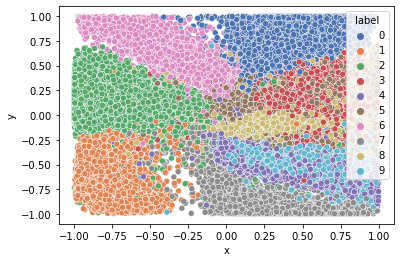

In [56]:
df = {"x":[],"y":[],"label":[]}
for x,y in tqdm.notebook.tqdm(data):
    df["label"].append(y)
    coords = model.encoder(x.cuda().unsqueeze(0)).squeeze()
    coords = coords.cpu().detach().numpy()
    df["x"].append(coords[0])
    df["y"].append(coords[1])
df = pd.DataFrame.from_dict(df)
sns.scatterplot(data=df, x="x", y="y",hue="label",palette="deep")

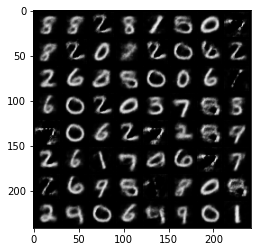

In [57]:
def generate_grid(latent_size,model):
    tmp = torch.randn(64,latent_size).cuda()
    op = model.decoder(tmp)
    grid = torchvision.utils.make_grid(op, nrow = 8, padding = 2, pad_value = 0.0)
    plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
    plt.show()
generate_grid(2,model)